In [702]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)
# dev_new = qml.device('default.qubit', wires=2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [703]:
Tau_global, Phi_global = np.zeros(3), 0
Gamma_ps_global = 0

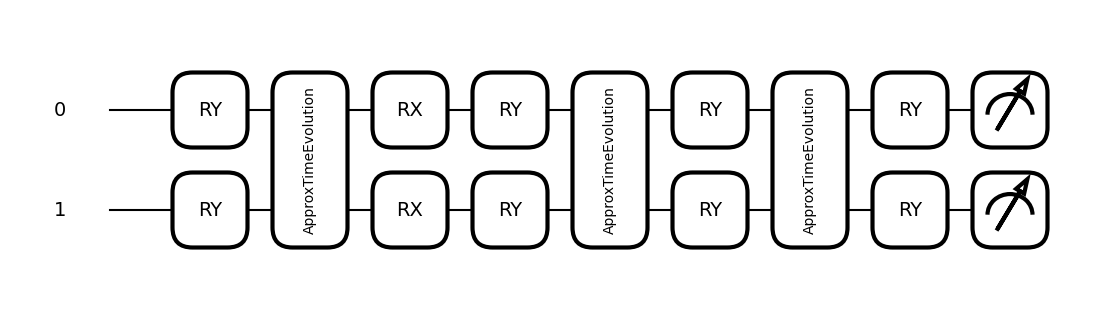

In [704]:
# 1-layer
@qml.qnode(dev)
def circuit_alt(phi_in):
    global Tau_global, Phi_global
    
    theta_init, tau_1, tau_2,  = [1e-3]*3
    phi = phi_in
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    # qml.RX(np.pi/2, wires=0)
    # qml.RX(np.pi/2, wires=1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_alt)(0)

In [705]:
type(circuit_alt(np.pi))

numpy.ndarray

In [706]:
rho = np.zeros((2 ** 2, 2 ** 2), dtype=np.complex128)

type(rho)

pennylane.numpy.tensor.tensor

In [707]:
@qml.qnode(dev)
def Post_selection_alt(phi):
    global Gamma_ps_global
    Gamma_ps = Gamma_ps_global
        
    # Get density matrix from circuit_2
    density_matrix = np.zeros((4, 4), dtype=np.complex128)
    density_matrix = circuit_alt(phi)
    
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])

In [708]:
Post_selection_alt(np.pi)

array([[ 2.49999979e-07-7.02020886e-20j,  2.64697796e-23-1.08420217e-19j,
        -2.08166288e-17-5.42101086e-20j, -9.99999167e-07+4.99998917e-04j],
       [-2.77555624e-17+5.42101086e-20j,  1.38777878e-17-7.02021046e-20j,
         6.93889390e-18+1.08420217e-19j, -1.59594613e-16-2.71050543e-20j],
       [-2.77555227e-17+8.13151629e-20j, -1.38777878e-17+2.71050543e-20j,
        -1.11022302e-16+6.53231669e-20j, -3.05311332e-16+2.71050543e-20j],
       [-9.99999167e-07-4.99998917e-04j, -1.80411294e-16+2.71050543e-20j,
        -2.22044605e-16+2.71050543e-20j,  9.99999750e-01+7.50810263e-20j]])

In [709]:
# @qml.qnode(dev_new)
# def circuit_after(phi_input):
#     Post_selection_alt(phi_input)
    
#     qml.qubit
    
#     return qml.density_matrix(wires=[0, 1])

# Gamma_ps_global = 0.7
# circuit_after(np.pi)

In [710]:
def Sweep(Sweep_bound, Gamma_ps_in):
    
    PHI = np.arange(Sweep_bound[0], Sweep_bound[1], Sweep_bound[2]).reshape(-1, 1)
    # PHI = np_.round(PHI, 9)
    # PHI = np.array(PHI)
    
    Data = np.zeros((len(PHI), 1 + len(Gamma_ps_in)))
    
    Data[:, 0] = PHI.squeeze()
    
    GAMMA_INDEX_IN_DATA = 1
    
    global Gamma_ps_global
    
    
    for Gamma_index in range(len(Gamma_ps_in)):
        Gamma_ps_global = Gamma_ps_in[Gamma_index]
        
        for i in range(len(PHI)):
            Data[i][Gamma_index + GAMMA_INDEX_IN_DATA] = qml.qinfo.classical_fisher(Post_selection_alt)(PHI[i])
        

    return Data

In [712]:
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, np.pi/(25*2)])
Gamma_ps_desired = 0.3, 0.4, 0.7, 0.8

Result = Sweep(Sweep_data, Gamma_ps_desired)

# print(Result)

# Result[:,0]

print(Result)

[[1.00000000e-04 2.04080829e+00 2.77776561e+00 1.11110064e+01
  2.49995544e+01]
 [6.29318531e-02 2.03648379e+00 2.76771657e+00 1.08851025e+01
  2.38178787e+01]
 [1.25763706e-01 2.02387909e+00 2.73857416e+00 1.02617021e+01
  2.08014170e+01]
 [1.88595559e-01 2.00327922e+00 2.69135686e+00 9.34183532e+00
  1.69341526e+01]
 [2.51427412e-01 1.97513043e+00 2.62765198e+00 8.25429801e+00
  1.31219444e+01]
 [3.14259265e-01 1.94002545e+00 2.54950738e+00 7.12070221e+00
  9.87136214e+00]
 [3.77091118e-01 1.89867607e+00 2.45928949e+00 6.03328299e+00
  7.32400236e+00]
 [4.39922972e-01 1.85188191e+00 2.35953287e+00 5.04857838e+00
  5.41990755e+00]
 [5.02754825e-01 1.80049780e+00 2.25279700e+00 4.19216054e+00
  4.02997434e+00]
 [5.65586678e-01 1.74540186e+00 2.14154230e+00 3.46781327e+00
  3.02427187e+00]
 [6.28418531e-01 1.68746609e+00 2.02803298e+00 2.86652594e+00
  2.29629546e+00]
 [6.91250384e-01 1.62753098e+00 1.91427003e+00 2.37329259e+00
  1.76620962e+00]
 [7.54082237e-01 1.56638487e+00 1.801953

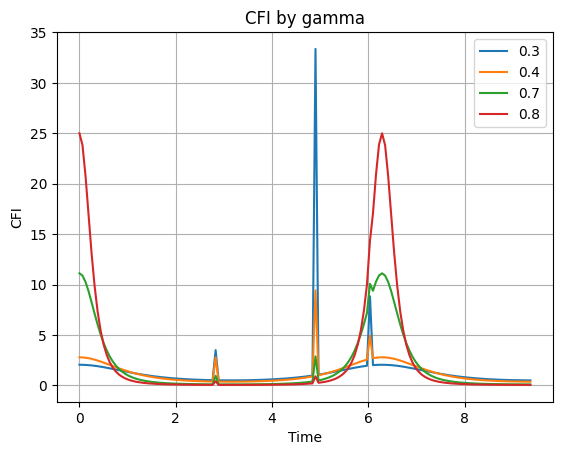

In [716]:
plt.plot(Result[:,0], Result[:,1], label = 0.3)
plt.plot(Result[:,0], Result[:,2], label = 0.4)
plt.plot(Result[:,0], Result[:,3], label = 0.7)
plt.plot(Result[:,0], Result[:,4], label = 0.8)

plt.title('CFI by gamma')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [714]:
import random

array = np_.zeros(4)

array[:4] = random.uniform(0,1)

array = np_.round(array, 3)
array = np.array(array)

array

tensor([0.465, 0.465, 0.465, 0.465], requires_grad=True)

In [715]:
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, np.pi/(25*2)])
Gamma_ps_desired = 0.6

Result = Sweep(Sweep_datas, Gamma_ps_desired)

# print(Result)

# Result[:,0]

NameError: name 'Sweep_datas' is not defined

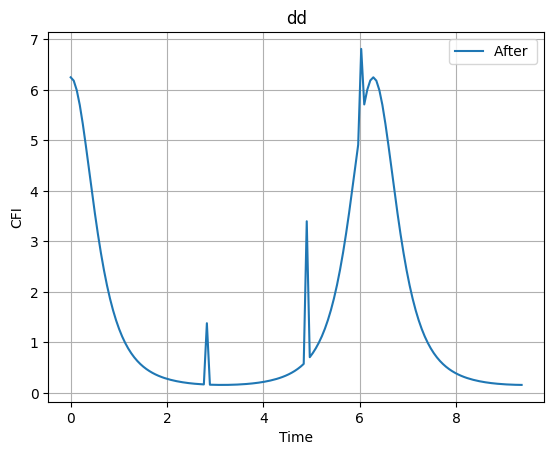

In [ ]:
plt.plot(Result[:, 0], Result[:, 1], label = 'After ')
    
plt.title('dd')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [ ]:
gamma_desired = 0.3, 0.4, 0.6, 0.7
Data_Set = 